In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "temperature-sweep-1.json",
    "temperature-sweep-2.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

289 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'no-role.txt',
   'user_prompt_template': 'cq.txt',
   'few_shot_examples': 'empty.json'},
  'run': 1},
 'metrics': {}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])
df = df[df["params.dataset.path"] == "bdsaglam/musique"].copy()
df.drop(columns=[col for col in df.columns if 'fuzzy' in col], inplace=True)

param_cols = [
    "params.dataset.path",
    "params.dataset.name",
    "params.dataset.split",
    "params.qa.model",
    "params.qa.temperature",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.run",
]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")
df.drop_duplicates(subset=param_cols, inplace=True)

In [4]:
def parse_qa_technique(system_prompt_filename):
    if "cte" in system_prompt_filename:
        return "CTE"
    if "cot" in system_prompt_filename:
        return "COT"
    return "Standard"

df["params.qa.technique"] = df["params.qa.system_prompt"].map(parse_qa_technique)

In [5]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [6]:
df['params.qa.n_shot'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [7]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,1,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,2,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,3,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning.txt,cq.txt,empty.json,1,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning.txt,cq.txt,empty.json,2,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal.txt,cq.txt,empty.json,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Standard,0
283,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal.txt,cq.txt,empty.json,3,0.000414,0.000532,0.000799,0.001027,0.000000,0.000000,0.000000,0.000000,Standard,0
284,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal.txt,cq.txt,empty.json,1,0.000000,0.000241,0.000000,0.000465,0.000000,0.000000,0.000000,0.000000,Standard,0
285,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal.txt,cq.txt,empty.json,2,0.000000,0.000033,0.000000,0.000064,0.000000,0.000000,0.000000,0.000000,Standard,0


In [8]:
df['params.qa.system_prompt'].unique().tolist()

['cot/excellent-format-reasoning.txt',
 'cot/format-minimal.txt',
 'cot/format-reasoning.txt',
 'cot/format-think.txt',
 'standard/excellent-few.txt',
 'standard/excellent-fewest.txt',
 'standard/helpful-output-format-few.txt',
 'standard/minimal-output-format-few-no-prio.txt',
 'standard/minimal-output-format-few.txt',
 'standard/minimal-output-format-fewest.txt',
 'standard/minimal-output-format.txt',
 'standard/minimal.txt']

In [9]:
def parse_system_prompt(system_prompt_filename):
    return system_prompt_filename.replace(".txt", "")

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(parse_system_prompt)

In [10]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
89,standard/minimal-output-format-fewest,cq.txt,empty.json,0.1,"(1, 3)"


In [11]:
# Filter out experiments with F1 score < 0.1
df_filtered = df[df['metrics.f1'] >= 0.1].copy().reset_index()
df_filtered.shape

(263, 20)

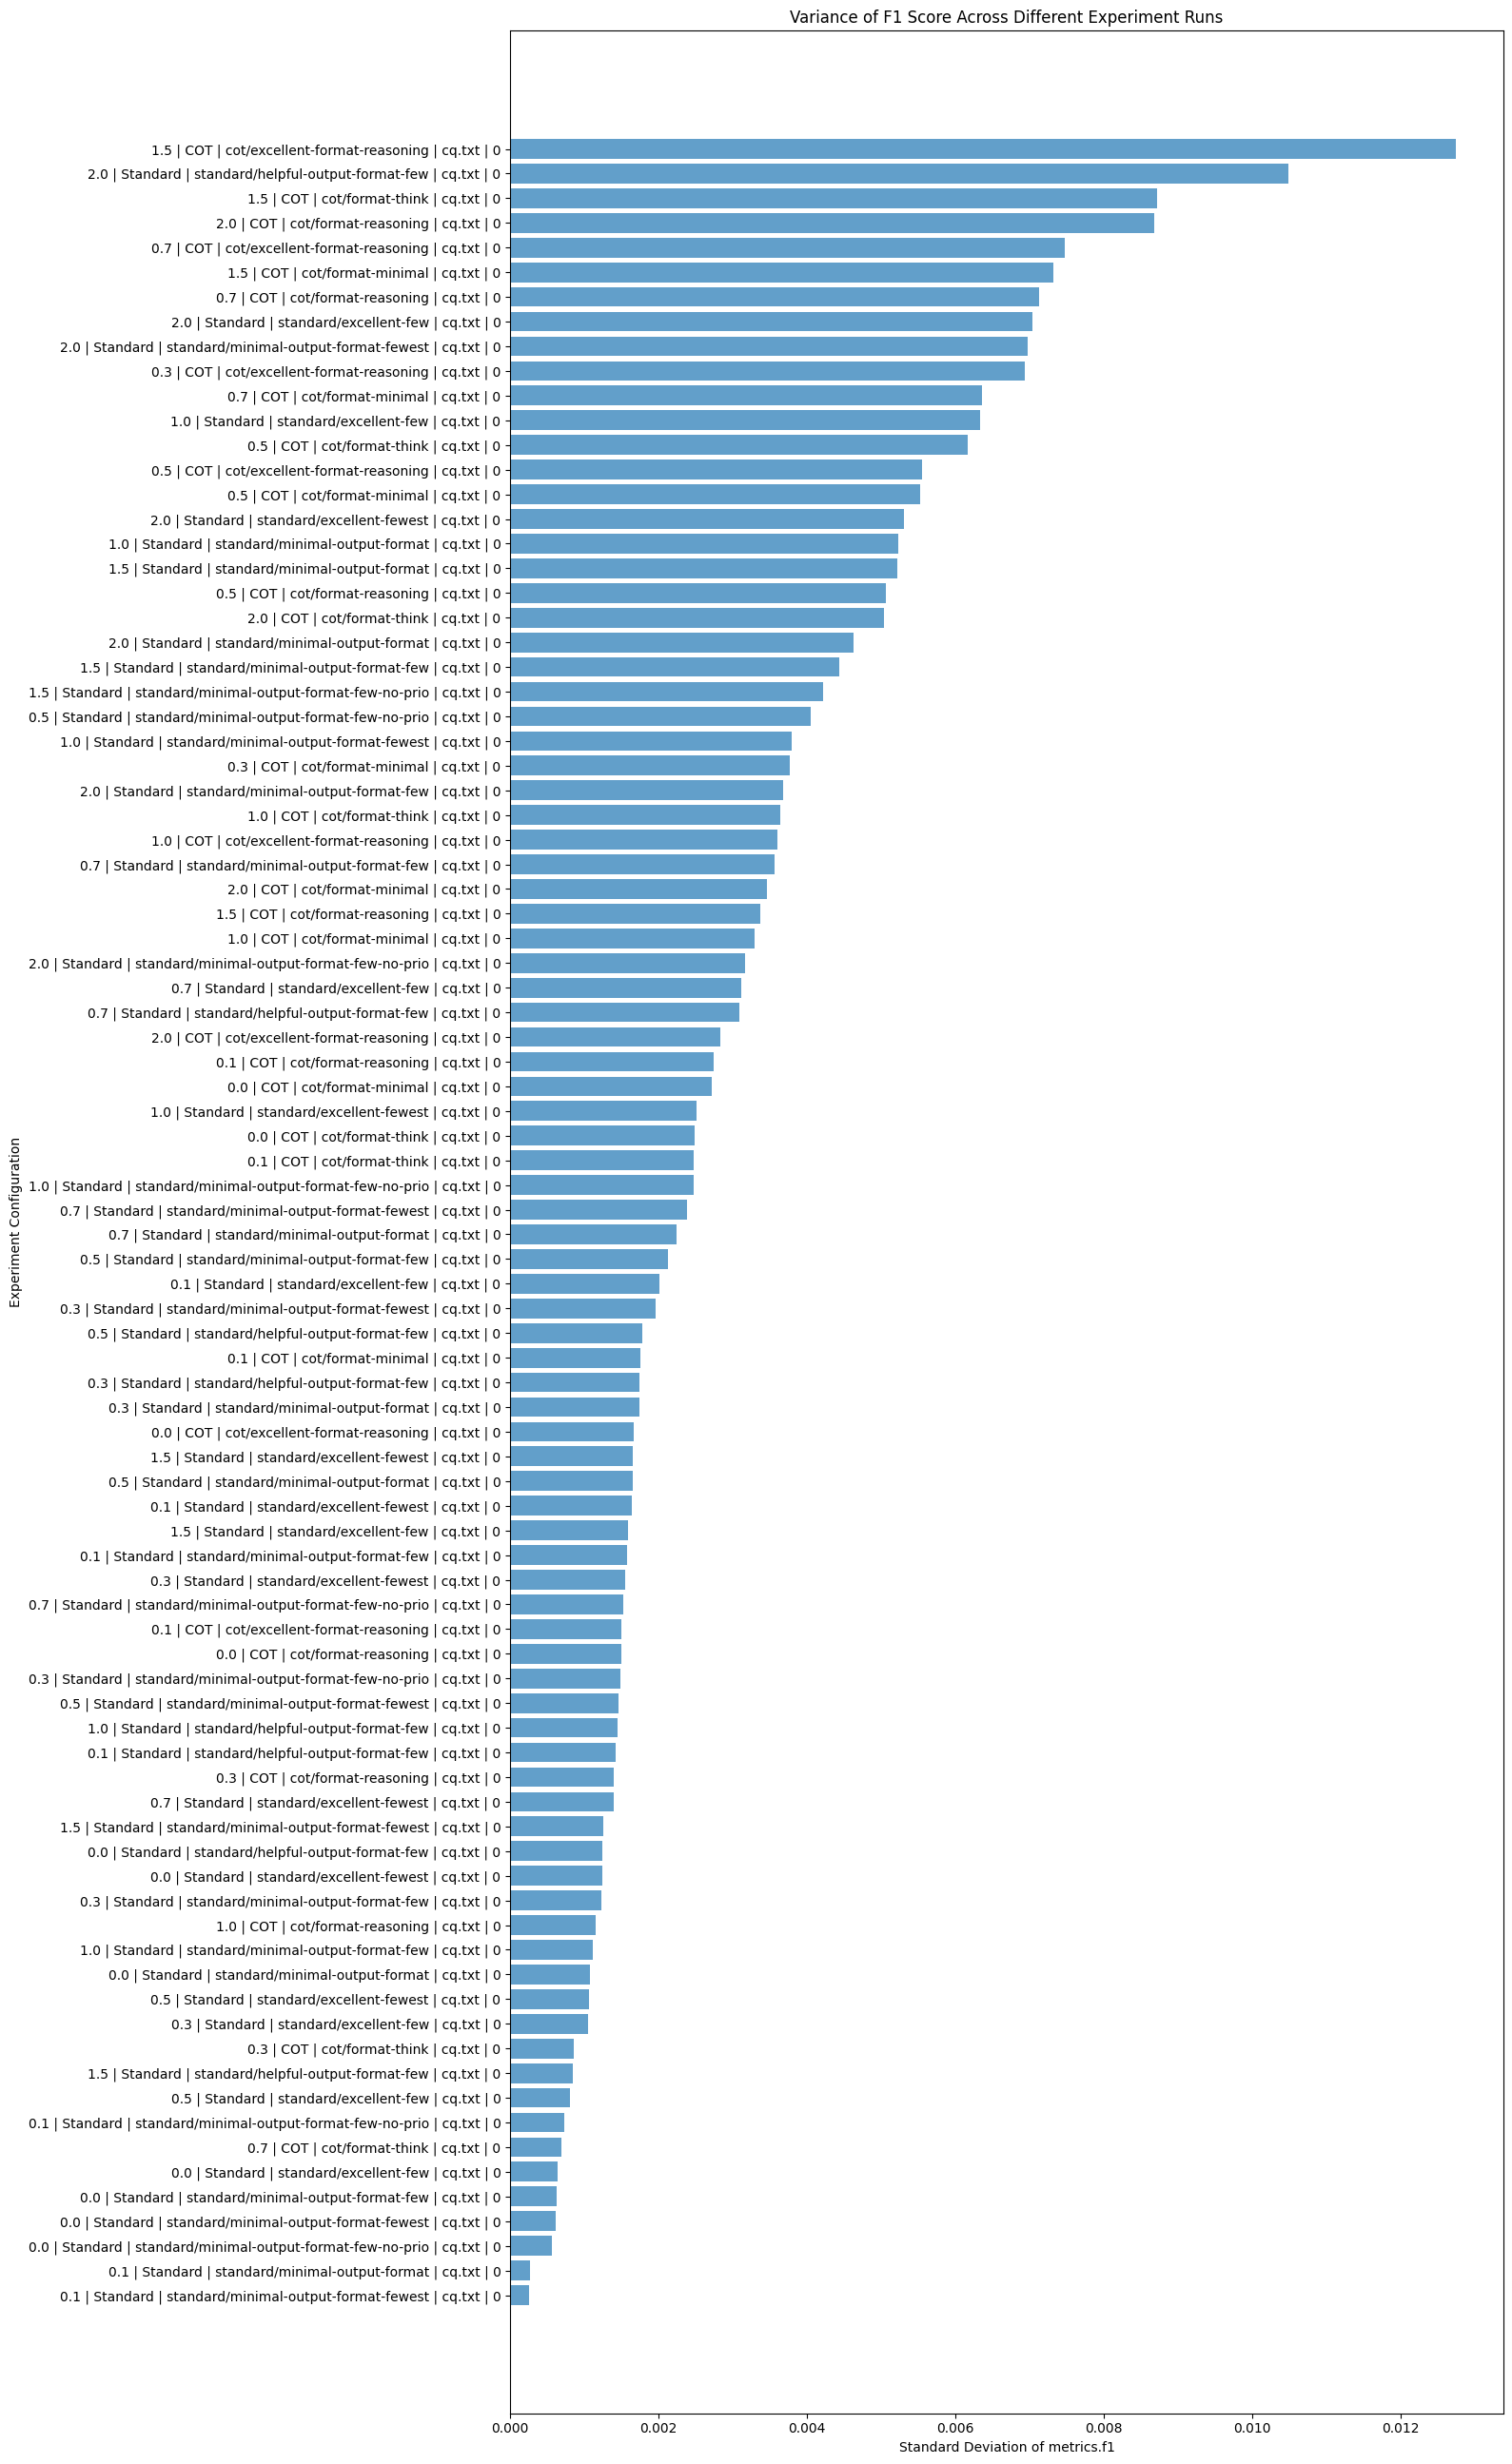

In [12]:
def plot_variance(dataf, metric_column):
    # Calculate variance of the specified metric for each experiment group
    grouped_dataf = dataf.groupby([
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot'
    ])[metric_column].std().reset_index()
    grouped_dataf.rename(columns={metric_column: f'{metric_column}_std'}, inplace=True)

    # Creating a unique label for each experiment configuration
    grouped_dataf['experiment_label'] = grouped_dataf[
        ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    ].apply(lambda x: ' | '.join(map(str, x)), axis=1)

    # Sort by variance for better visual clarity
    grouped_dataf.sort_values(f'{metric_column}_std', inplace=True)

    # Plot
    metric_name = metric_column.split(".")[-1].upper()
    plt.figure(figsize=(16, int(len(grouped_dataf)*0.3)))
    plt.barh(grouped_dataf['experiment_label'], grouped_dataf[f'{metric_column}_std'], alpha=0.7)
    plt.xlabel(f'Standard Deviation of {metric_column}')
    plt.ylabel('Experiment Configuration')
    plt.title(f'Variance of {metric_name} Score Across Different Experiment Runs')
    plt.tight_layout()
    plt.show()

plot_variance(df_filtered, 'metrics.f1')


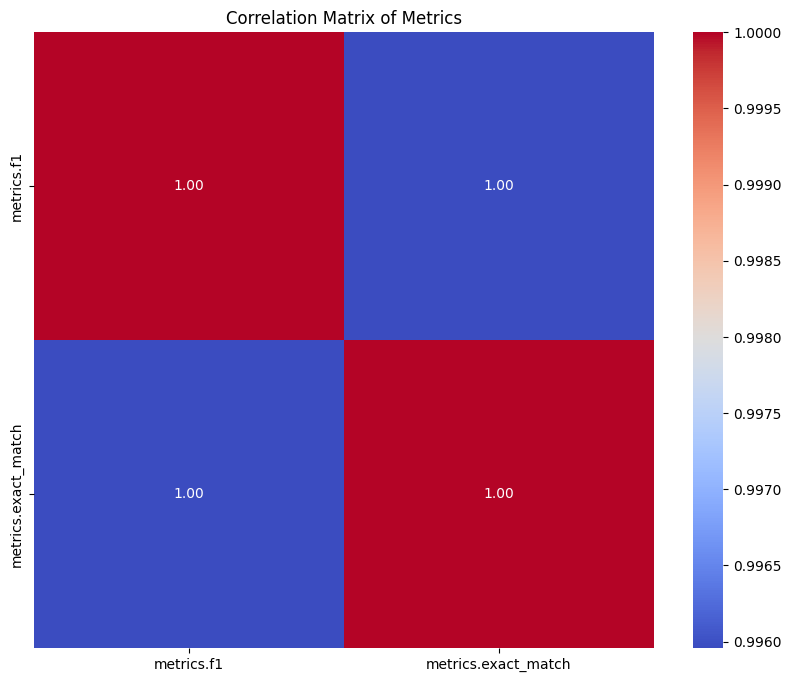

In [13]:

def analyze_correlation(dataf, metric_columns):
    correlation_matrix = dataf[metric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Metrics')
    plt.show()

analyze_correlation(df_filtered, ['metrics.f1', 'metrics.exact_match'])



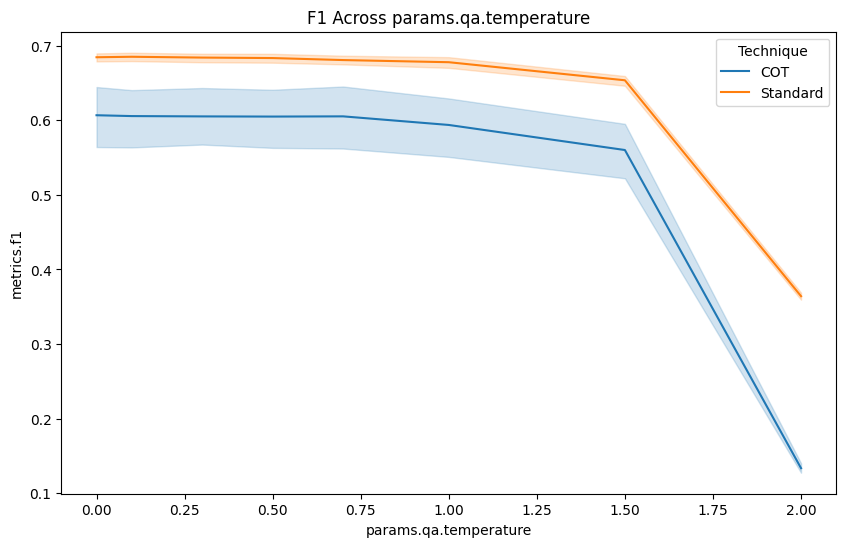

In [14]:
def performance_trends(dataf, metric_column, parameter):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataf, x=parameter, y=metric_column, hue='params.qa.technique')
    plt.title(f'{metric_column.split(".")[-1].capitalize()} Across {parameter}')
    plt.xlabel(parameter)
    plt.ylabel(metric_column)
    plt.legend(title='Technique')
    plt.show()

performance_trends(df_filtered, 'metrics.f1', 'params.qa.temperature')


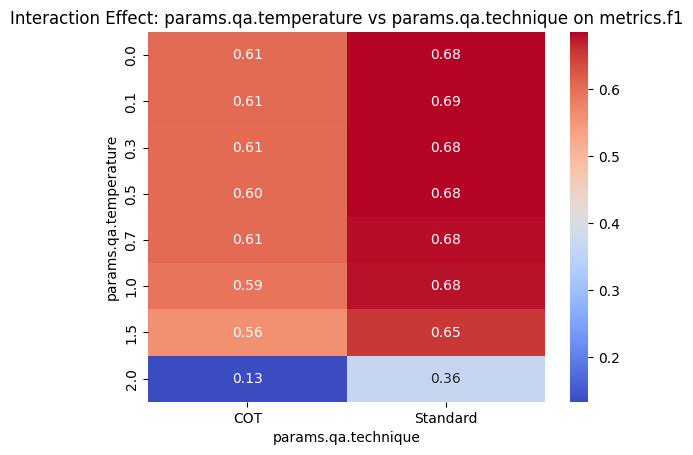

In [15]:

def interaction_effects(dataf, metric_column, param1, param2):
    pivot_table = dataf.pivot_table(index=param1, columns=param2, values=metric_column, aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Interaction Effect: {param1} vs {param2} on {metric_column}')
    plt.show()

interaction_effects(df_filtered, 'metrics.f1', 'params.qa.temperature', 'params.qa.technique')


In [16]:
def top_n_configurations(dataf, metric_column, n=5):
    top_configs = dataf.nlargest(n, metric_column)
    print("Top Configurations:")
    print(top_configs[[
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot',
        metric_column
    ]])

top_n_configurations(df_filtered, 'metrics.f1', n=5)

Top Configurations:
     params.qa.temperature params.qa.technique  \
153                    0.5            Standard   
197                    0.1            Standard   
202                    0.5            Standard   
192                    0.0            Standard   
157                    0.7            Standard   

                params.qa.system_prompt params.qa.user_prompt_template  \
153  standard/helpful-output-format-few                         cq.txt   
197  standard/minimal-output-format-few                         cq.txt   
202  standard/minimal-output-format-few                         cq.txt   
192  standard/minimal-output-format-few                         cq.txt   
157  standard/helpful-output-format-few                         cq.txt   

     params.qa.n_shot  metrics.f1  
153                 0    0.701265  
197                 0    0.700948  
202                 0    0.700405  
192                 0    0.700158  
157                 0    0.700047  


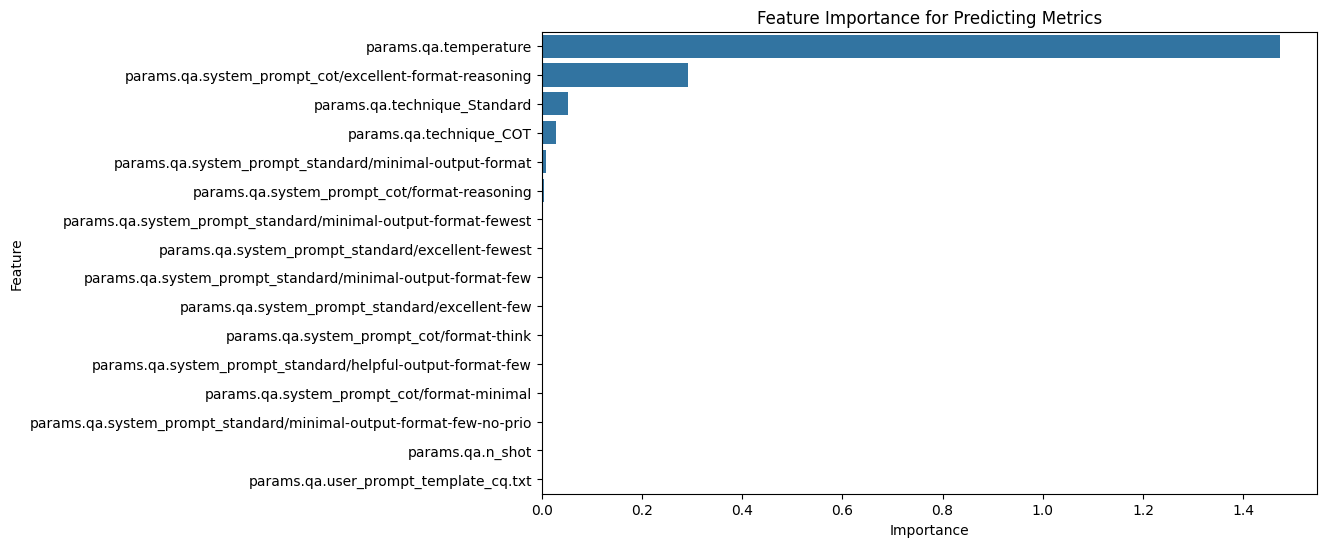

In [17]:
def feature_importance(dataf, metric_column):
    # Prepare data
    feature_columns = ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    X = pd.get_dummies(dataf[feature_columns])
    y = dataf[metric_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    importance = permutation_importance(model, X_test, y_test, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Predicting Metrics')
    plt.show()


# Perform analyses
feature_importance(df_filtered, 'metrics.f1')